# Loading the Data

In [59]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import glob

observation_df = pd.read_csv('observations.csv', encoding='utf-8')
species_info_df = pd.read_csv('species_info.csv', encoding='utf-8')

print(observation_df.head())
print(species_info_df.head())

print(observation_df.info())
print(species_info_df.info())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic 

# Exploring the Data

In [19]:
print(f"species info shape: {species_info_df.shape}")
print(f"observation shape: {observation_df.shape}")

species info shape: (5824, 4)
observation shape: (23296, 3)


In [25]:
print(f"number of species:{species_info_df.scientific_name.nunique()}")


number of species:5541


In [23]:
print(f"number of categories:{species_info_df.category.nunique()}")
print(f"categories:{species_info_df.category.unique()}")

number of categories:7
categories:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [26]:
species_info_df.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

### Conservation Status

In [29]:
print(f"number of conservation statuses: {species_info_df.conservation_status.nunique()}")
print(f"unique conservation statuses: {species_info_df.conservation_status.unique()}")

number of conservation statuses: 4
unique conservation statuses: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


### NaN Values (species info)

In [30]:
print(f"number of na values:{species_info_df.conservation_status.isna().sum()}")
print(species_info_df.groupby("conservation_status").size())

number of na values:5633
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


In [34]:
print(f"number of parks:{observation_df.park_name.nunique()}") 
print(f"park names:{observation_df.park_name.unique()}")

number of parks:4
park names:['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [35]:
print(f"number of observations:{observation_df.observations.sum()}")

number of observations:3314739


# Analysis
-Converting NaN values to "No Intervention", as these species are not at risk or of any concern.

In [108]:
species_info_df.fillna("No Intervention", inplace=True)
species_info_df.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

In [44]:
conservation_category = species_info_df[species_info_df.conservation_status != "No Intervention"]\
.groupby(["conservation_status","category"])['scientific_name']\
.count().unstack()

conservation_category

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


Text(0, 0.5, 'Number of Species')

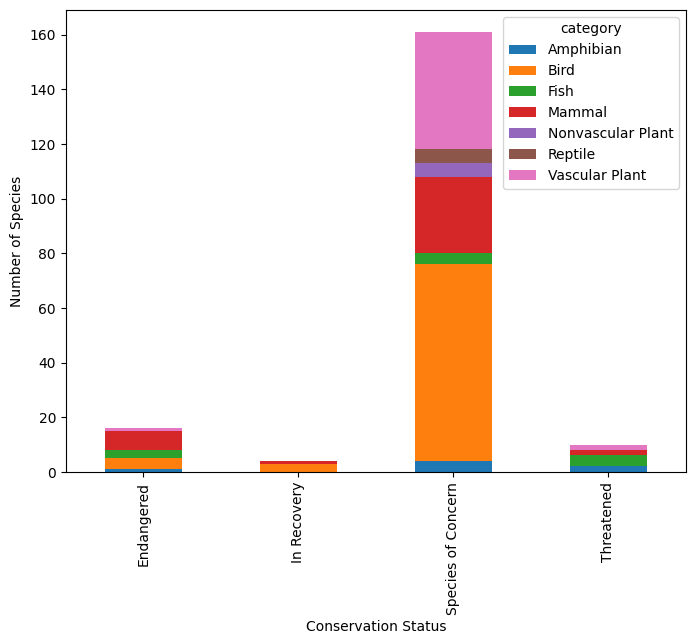

In [45]:
bar_chart = conservation_category.plot(kind= 'bar', figsize = (8,6), stacked = True)
bar_chart.set_xlabel('Conservation Status')
bar_chart.set_ylabel('Number of Species')

### Are certain types of species more likely to be endangered?

In [137]:
species_info_df['is_protected'] = species_info_df.conservation_status != 'No Intervention'
print(species_info_df.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  \
0                           Gapper's Red-Backed Vole     No Intervention   
1                              American Bison, Bison     No Intervention   
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...     No Intervention   
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)     No Intervention   
4                                      Wapiti Or Elk     No Intervention   

   is_bat  is_protected  
0   False         False  
1   False         False  
2   False         False  
3   False         False  
4   False         False  


In [49]:
category_counts = species_info_df.groupby(['category','is_protected']).scientific_name.nunique().reset_index()\
.pivot(
    columns='is_protected',
    index='category',
    values='scientific_name'
).reset_index()

category_counts.columns = ['category', 'not_protected', 'protected']

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [57]:
category_counts['percent_protected'] = category_counts.protected / (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


## Chi-Square Test - Conservation status rates
#### Birds & Mammals

In [63]:
contingency1 = [[75, 413],[30, 146]]
chi2_contingency(contingency1)

Chi2ContingencyResult(statistic=np.float64(0.16170148316545574), pvalue=np.float64(0.6875948096661336), dof=1, expected_freq=array([[ 77.1686747, 410.8313253],
       [ 27.8313253, 148.1686747]]))

#### Reptiles & Mammals

In [66]:
contingency2 = [[5, 73], [30, 146]]
chi2_contingency(contingency2)

Chi2ContingencyResult(statistic=np.float64(4.289183096203645), pvalue=np.float64(0.03835559022969898), dof=1, expected_freq=array([[ 10.7480315,  67.2519685],
       [ 24.2519685, 151.7480315]]))

In [87]:
from itertools import chain
import string

def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_names = species_info_df[species_info_df.category == 'Mammal'].common_names.apply(remove_punctuation).str.split().tolist()

common_names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

##### Clean up data (remove duplicates)

In [88]:
clean_rows = []

for item in common_names:
    item = list(dict.fromkeys(item))
    clean_rows.append(item)
    
clean_rows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [89]:
result = list(chain.from_iterable(i if isinstance(i, list) else [i] for i  in clean_rows))
result[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [92]:
result[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [95]:
words_counted = []

for animal in result:
    x = result.count(animal)
    words_counted.append((animal,x))

pd.DataFrame(set(words_counted), columns = ['Word', 'Count']).sort_values("Count", ascending = False).head(10).reset_index(drop=True)

,Word,Count
0,Bat,23
1,Shrew,18
2,Myotis,17
3,Mouse,16
4,Chipmunk,13
5,Squirrel,12
6,American,12
7,Vole,11
8,Eastern,11
9,Mountain,10


### Which row of species is referring to bats? 

In [127]:
species_info_df['is_bat'] = species_info_df.common_names.str.contains(r'\bBat\b' , regex=True)
species_info_df.head(5)

,category,scientific_name,common_names,conservation_status,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False


##### Subset of species data where is_bat is True

In [125]:
species_info_df[species_info_df.is_bat]

,category,scientific_name,common_names,conservation_status,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,True


#### Merging the results of the Bat Species table with the Observations table to create a DF with observations of bats across the 4 different national parks. 

In [140]:
bat_observations = observation_df.merge(species_info_df[species_info_df.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_bat,is_protected
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,True,False
2,Nycticeius humeralis,Yellowstone National Park,219,Mammal,Evening Bat,No Intervention,True,False
3,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
4,Lasiurus borealis,Yosemite National Park,134,Mammal,"Eastern Red Bat, Red Bat",No Intervention,True,False
...,...,...,...,...,...,...,...,...
139,Eptesicus fuscus,Bryce National Park,72,Mammal,Big Brown Bat,Species of Concern,True,True
140,Eptesicus fuscus,Bryce National Park,72,Mammal,"Big Brown Bat, Big Brown Bat",Species of Concern,True,True
141,Myotis leibii,Yellowstone National Park,233,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Lasionycteris noctivagans,Bryce National Park,128,Mammal,Silver-Haired Bat,Species of Concern,True,True


In [141]:
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


#### Protected Bats vs. Non-protected Bats

In [143]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


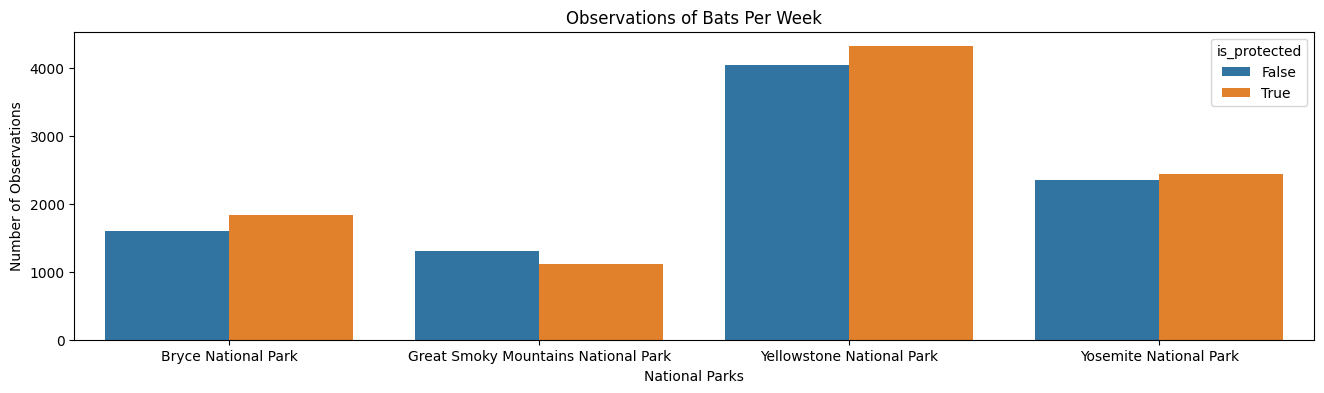

In [145]:
plt.figure(figsize=(16,4))
sns.barplot(x=obs_by_park.park_name, y=obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats Per Week')
plt.show()